In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pythainlp.tokenize import word_tokenize
from underthesea import word_tokenize as vn_tokenize
import seaborn as sns
from transformers import AutoTokenizer
import re
import duckdb
import underthesea

In [2]:
# Connect to DuckDB (creates a file-based DB)
con = duckdb.connect("translation.db")

print(con.execute("SELECT * FROM translations LIMIT 5").fetchdf())

                                  thai  \
0                    - รร.แกรนด์โฮเต็ล   
1                         - สายไม่ว่าง   
2                         นั่นใครพูดคะ   
3  ฉันจะโอนสายคุณ ไปที่แผนกรูมเซอร์วิส   
4                              ฮัลโหลๆ   

                                        vietnamese  
0                               - Khách sạn Grand.  
1                                 - Đường dây bận.  
2                                          Ai đấy?  
3  Tôi có thể kết nối quý khách với dịch vụ phòng.  
4                                            A lô.  


In [ ]:
# Load CSV (replace with your file path)
dataset = pd.read_csv(r"c:\Carrer\Data_science\Thesis_bachelor\Data\preprocess.csv")  # Columns: thai, vietnamese

# Store in DuckDB as a table
con.execute("CREATE TABLE translations (thai VARCHAR, vietnamese VARCHAR)")
con.execute("INSERT INTO translations SELECT * FROM dataset")

# Verify data
print(con.execute("SELECT * FROM translations LIMIT 5").fetchdf())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

                                  thai  \
0                    - รร.แกรนด์โฮเต็ล   
1                         - สายไม่ว่าง   
2                         นั่นใครพูดคะ   
3  ฉันจะโอนสายคุณ ไปที่แผนกรูมเซอร์วิส   
4                              ฮัลโหลๆ   

                                        vietnamese  
0                               - Khách sạn Grand.  
1                                 - Đường dây bận.  
2                                          Ai đấy?  
3  Tôi có thể kết nối quý khách với dịch vụ phòng.  
4                                            A lô.  


In [ ]:
import tiktoken
import google.protobuf
# Load a tokenizer (e.g., for mBART, or use SentencePiece for custom models)
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-1.3B")

# Fetch data from DuckDB
df = con.execute("SELECT thai, vietnamese FROM translations").fetchdf()

# Tokenize Thai and Vietnamese
def tokenize_pair(row):
    thai_tokens = tokenizer.encode(row["thai"], add_special_tokens=False)
    viet_tokens = tokenizer.encode(row["vietnamese"], add_special_tokens=False)
    return pd.Series({"thai_tokens": thai_tokens, "viet_tokens": viet_tokens})

# Apply tokenization (process in batches for 2GB)
batch_size = 10000
tokenized_dfs = []
for i in range(0, len(df), batch_size):
    batch = df[i:i + batch_size]
    tokenized_batch = batch.apply(tokenize_pair, axis=1)
    tokenized_dfs.append(tokenized_batch)

tokenized_df = pd.concat(tokenized_dfs)

# Store back in DuckDB
con.execute("CREATE TABLE tokenized_translations (thai_tokens VARCHAR, viet_tokens VARCHAR)")
con.execute("INSERT INTO tokenized_translations SELECT * FROM tokenized_df")

# Verify
print(con.execute("SELECT * FROM tokenized_translations LIMIT 5").fetchdf())
con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [19]:
pip install sentencepiece

   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   ---

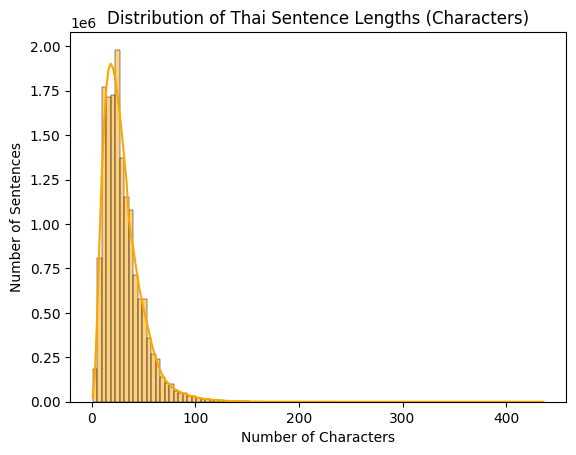

In [13]:
sns.histplot(df_lengths['thai_len_char'], bins=100, kde=True, color='orange')
plt.title('Distribution of Thai Sentence Lengths (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Number of Sentences')
plt.show()


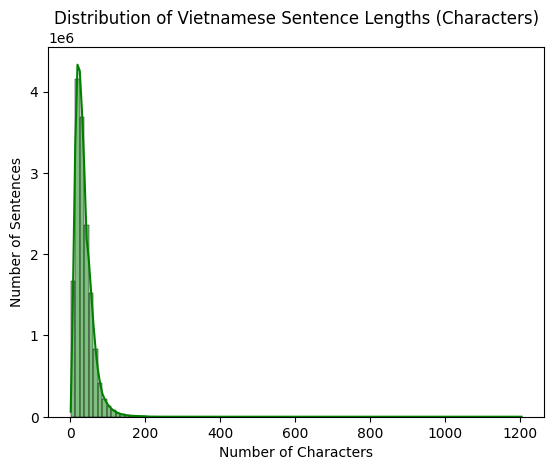

In [14]:
sns.histplot(df_lengths['viet_len_char'], bins=100, kde=True, color='green')
plt.title('Distribution of Vietnamese Sentence Lengths (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Number of Sentences')
plt.show()


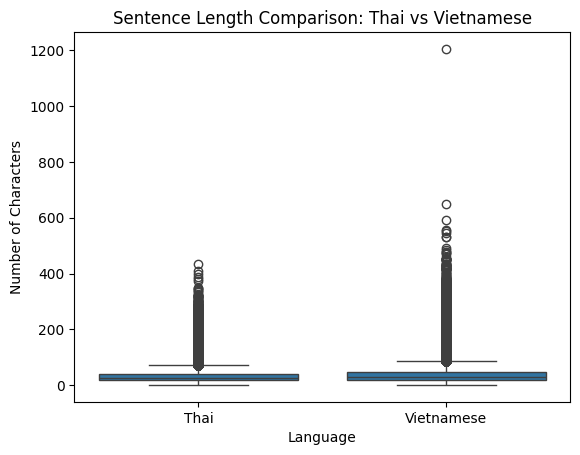

In [15]:
import pandas as pd
df_melted = pd.melt(df_lengths, var_name='Language', value_name='Length')
df_melted['Language'] = df_melted['Language'].replace({
    'thai_len_char': 'Thai',
    'viet_len_char': 'Vietnamese'
})

sns.boxplot(x='Language', y='Length', data=df_melted)
plt.title('Sentence Length Comparison: Thai vs Vietnamese')
plt.ylabel('Number of Characters')
plt.xlabel('Language')
plt.show()


In [9]:
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-1.3B")

# 2. Define Python UDFs for DuckDB
def word_tokenize(text):
    if not isinstance(text, str):
        return []
    return re.findall(r'(\w+|[^\w\s])', text)

def hf_token_len(text):
    if not isinstance(text, str):
        return 0
    return len(tokenizer.tokenize(text))

def word_token_len(text):
    if not isinstance(text, str):
        return 0
    return len(word_tokenize(text))

# 3. Connect to DuckDB and register UDFs
con = duckdb.connect()
con.create_function("hf_token_len", hf_token_len, return_type="INTEGER")
con.create_function("word_token_len", word_token_len, return_type="INTEGER")

# 4. Import CSV into DuckDB virtual table
csv_path = r"c:\Carrer\Data_science\Thesis_bachelor\Data\preprocess.csv"

# Load data with SQL
query = f"""
SELECT 
    *,
    hf_token_len(Thai) AS thai_hf_len,
    hf_token_len(Viet) AS viet_hf_len,
    word_token_len(Thai) AS thai_word_len,
    word_token_len(Viet) AS viet_word_len
FROM read_csv_auto('{csv_path}', delim=',', header=True)
"""

df = con.execute(query).fetchdf()
print(df.head())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

InvalidInputException: Invalid Input Error: Python exception occurred while executing the UDF: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  C:\Users\Acer\AppData\Local\Temp\ipykernel_22736\2889407501.py(9): hf_token_len
  C:\Users\Acer\AppData\Local\Temp\ipykernel_22736\2889407501.py(38): <module>
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\IPython\core\interactiveshell.py(3549): run_code
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\IPython\core\interactiveshell.py(3489): run_ast_nodes
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\IPython\core\interactiveshell.py(3306): run_cell_async
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\IPython\core\async_helpers.py(128): _pseudo_sync_runner
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\IPython\core\interactiveshell.py(3102): _run_cell
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\IPython\core\interactiveshell.py(3047): run_cell
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\ipykernel\zmqshell.py(549): run_cell
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\ipykernel\ipkernel.py(449): do_execute
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\ipykernel\kernelbase.py(778): execute_request
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\ipykernel\ipkernel.py(362): execute_request
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\ipykernel\kernelbase.py(437): dispatch_shell
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\ipykernel\kernelbase.py(534): process_one
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\ipykernel\kernelbase.py(545): dispatch_queue
  c:\Users\Acer\anaconda3\envs\thesis\Lib\asyncio\events.py(84): _run
  c:\Users\Acer\anaconda3\envs\thesis\Lib\asyncio\base_events.py(1936): _run_once
  c:\Users\Acer\anaconda3\envs\thesis\Lib\asyncio\base_events.py(608): run_forever
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\tornado\platform\asyncio.py(205): start
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\ipykernel\kernelapp.py(739): start
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\traitlets\config\application.py(1075): launch_instance
  c:\Users\Acer\anaconda3\envs\thesis\Lib\site-packages\ipykernel_launcher.py(18): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main
